# Check GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Programing (E:)/Nhập Môn CV/Team/Mid-Term Report'

/content/drive/.shortcut-targets-by-id/1uJ336XEgQYZ4EctzzIjrNI5gtBJPe6QE/Team/Mid-Term Report


In [ ]:
!nvidia-smi

Tue Oct 26 02:15:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Package

In [4]:
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch
import os
from torchvision.models import vgg16
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from translate import translate
import warnings

warnings.filterwarnings('ignore')

# Data preprocessing

In [5]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = './data/animals10'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                    for x in ['train','val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=16)
                for x in ['train','val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = [translate[x] for x in image_datasets['train'].classes]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class_names, dataset_sizes

(['dog',
  'horse',
  'elephant',
  'butterfly',
  'chicken',
  'cat',
  'cow',
  'sheep',
  'spider',
  'squirrel'],
 {'test': 2000, 'train': 4000, 'val': 1000})

# Visualize data

In [8]:
def img_show(imgs, labels):
    num_img = len(imgs)
    # plt.figure(figsize=(20*num_img, 20))
    fig, ax = plt.subplots(1, num_img, figsize=(7*num_img, 7))
    # fig.figsize = (20*num_img, 20)
    for i, img in enumerate(imgs):
        img = img.numpy().transpose(1, 2, 0)
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(labels[i])
      

    plt.show()

In [10]:
import pandas as pd
import seaborn as sns
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.style.use('seaborn')

def draw_cf_matrix(cf_matrix, classes):
    sum = cf_matrix.sum()
    cf_matrix = cf_matrix * 1000.0 / ( 1.0 * sum )

    df_cm = pd.DataFrame(cf_matrix, 
    index = classes,
    columns = classes)

    fig = plt.figure()
    plt.clf()

    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    res = sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap=cmap)
    # res.invert_yaxis()
    plt.yticks(ticks=list(range(len(classes))), labels=classes, va='center')
    plt.title('Confusion Matrix')

    plt.show()

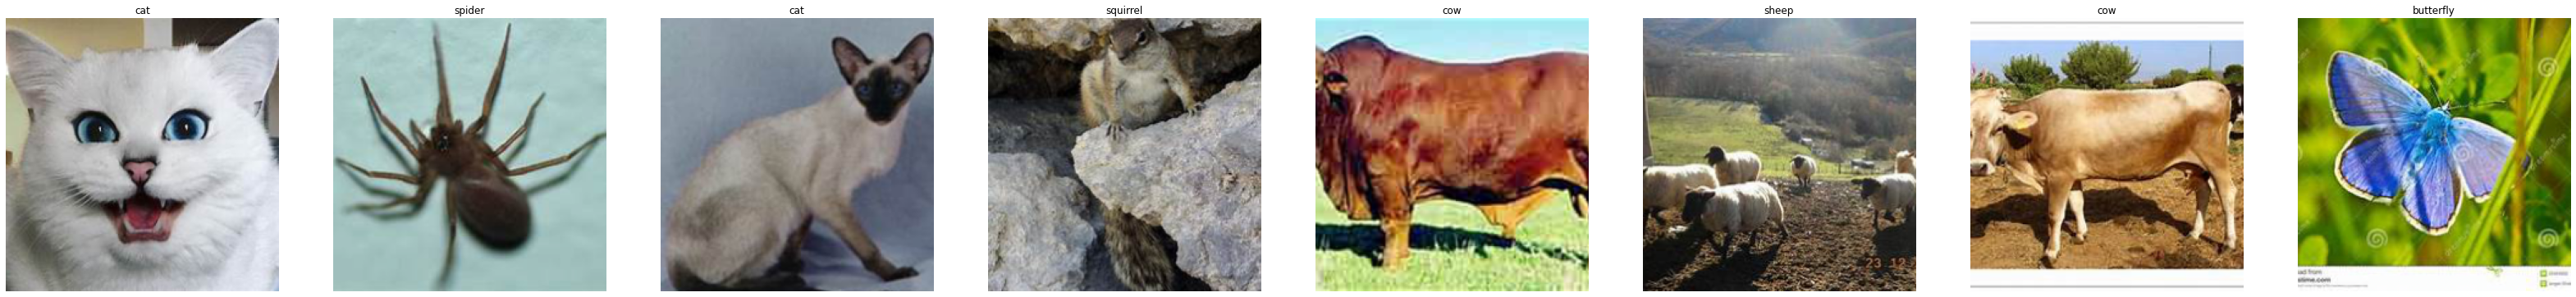

In [ ]:
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
img_show(inputs, [class_names[x] for x in classes])

# Define model

## Load VGG16 as base model

In [11]:
base_model = vgg16(pretrained=True).to('cuda')
summary(base_model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [12]:
list(base_model.classifier.children())

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=1000, bias=True)]

## Modify the last layer of model to use as Feature Extractor

In [13]:
class VGG16_custom(nn.Module):
  def __init__(self):
    super(VGG16_custom, self).__init__()
    self.features = nn.Sequential(*list(base_model.features.children()))
    self.avgpool = base_model.avgpool
    self.classifier = nn.Sequential(*list(base_model.classifier.children())[: -2])

  def forward(self,x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1) # Flatten
    x = self.classifier(x)
    return x

model_custom = VGG16_custom().to('cuda')
summary(model_custom, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Define Extractor function

In [14]:
def extract(model, dataloader):
    X_train = torch.tensor([]).to('cuda')
    y_train = torch.tensor([]).to('cuda')
    X_test = torch.tensor([]).to('cuda')
    y_test = torch.tensor([]).to('cuda')

    with torch.no_grad():
        for data in ['train', 'test']:
            for x, y in dataloaders[data]:
                x = x.to('cuda')
                y = y.to('cuda')
                model.eval()
                out = model(x)
                if data == 'train':
                    X_train = torch.cat((X_train, out),dim=0)
                    y_train = torch.cat((y_train, y), dim=0)
                else:
                    X_test = torch.cat((X_test, out),dim=0)
                    y_test = torch.cat((y_test, y), dim=0)

    X_train = X_train.cpu().detach().numpy()
    y_train = y_train.cpu().detach().numpy()
    X_test = X_test.cpu().detach().numpy()
    y_test = y_test.cpu().detach().numpy()

    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = extract(model_custom, dataloaders)

# Test model

In [ ]:
def extract_test(model, x):
    with torch.no_grad():
        features = torch.tensor([]).to('cuda')
        x = x.to('cuda')
        model.eval()
        features = model(x)
    return features.cpu().detach().numpy()

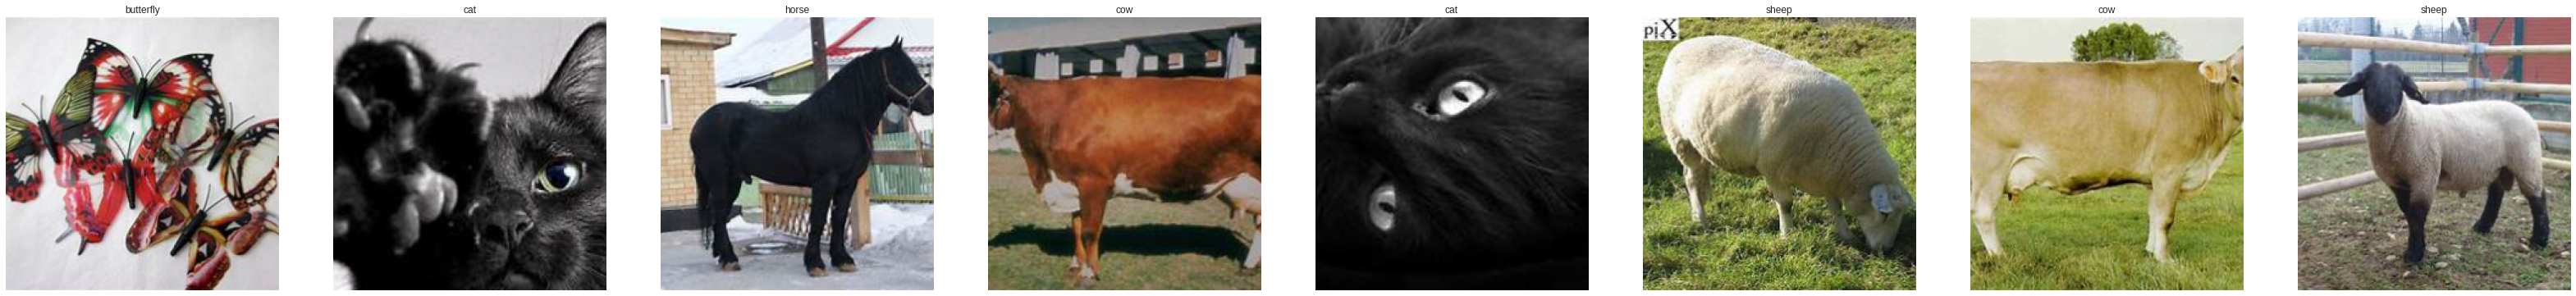

In [ ]:
inputs, classes = next(iter(dataloaders['test']))

features = extract_test(model_custom, inputs)
preds = svm_model.predict(features)

img_show(inputs, [class_names[x] for x in preds.astype(int)])

# SVM rbf

In [16]:
from sklearn import svm
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
y_pred = svm_model.predict(X_test)

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.9445
Recall:  0.9445
Precision:  0.9445
F1:  0.9445


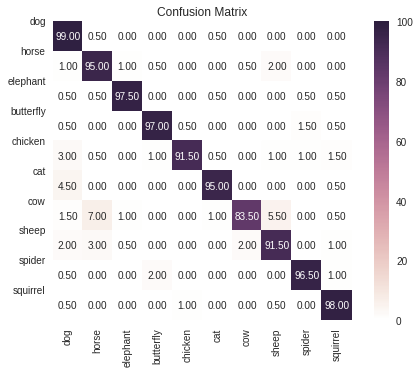

In [19]:
cf_matrix = confusion_matrix(y_test, y_pred)

draw_cf_matrix(cf_matrix, class_names)

# SVM sigmoid

In [20]:
from sklearn import svm
svm_model = svm.SVC(kernel='sigmoid')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
y_pred = svm_model.predict(X_test)

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.943
Recall:  0.943
Precision:  0.943
F1:  0.943


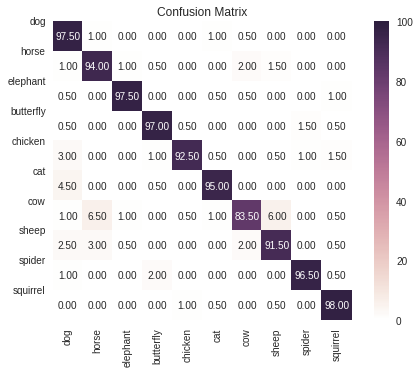

In [23]:
cf_matrix = confusion_matrix(y_test, y_pred)

draw_cf_matrix(cf_matrix, class_names)

# SVM poly

In [24]:
from sklearn import svm
svm_model = svm.SVC(kernel='poly')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [25]:
y_pred = svm_model.predict(X_test)

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.914
Recall:  0.914
Precision:  0.914
F1:  0.914


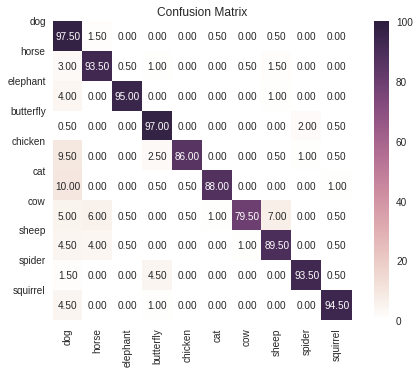

In [27]:
cf_matrix = confusion_matrix(y_test, y_pred)

draw_cf_matrix(cf_matrix, class_names)

# SVM linear

In [28]:
from sklearn import svm
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
y_pred = svm_model.predict(X_test)

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.9435
Recall:  0.9435
Precision:  0.9435
F1:  0.9435


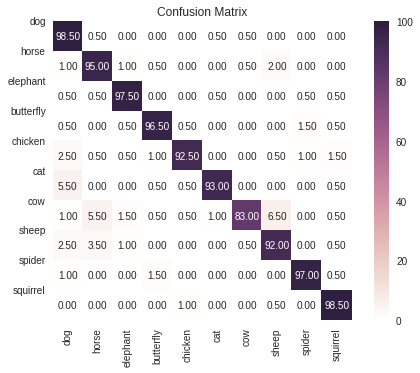

In [31]:
cf_matrix = confusion_matrix(y_test, y_pred)

draw_cf_matrix(cf_matrix, class_names)